<a href="https://colab.research.google.com/github/concaption/cats-vs-dogs/blob/main/cats_vs_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load data

In [1]:
import os
import shutil
import random
import numpy as np
from zipfile import ZipFile as unzip
from google.colab import files
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array, load_img

In [3]:
! pip install kaggle
! mkdir ~/.kaggle
! mv kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c dogs-vs-cats

 93% 251M/271M [00:01<00:00, 164MB/s]
100% 271M/271M [00:01<00:00, 175MB/s]
 98% 533M/543M [00:02<00:00, 197MB/s]
100% 543M/543M [00:03<00:00, 186MB/s]
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 88.5MB/s]


In [5]:
for _ , _  , filenames in os.walk('.'):
  for filename in filenames:
    if filename[-3:]=='zip':
      file = unzip(filename,'r')
      file.extractall()
      file.close()
      os.remove(filename)

os.remove('sampleSubmission.csv')

In [6]:
print("Number of train images: " , len(os.listdir('./train')) )
print("Number of test images: "  , len(os.listdir('./test1')) )

Number of train images:  25000
Number of test images:  12500


In [7]:
no_of_cats = len([files for files in os.listdir('./train') if 'cat' in files])
no_of_dogs = len([files for files in os.listdir('./train') if 'dog' in files])
print("Cat images in train dataset: ",  no_of_cats)
print("Dog images in train dataset: ", no_of_dogs)
if no_of_cats==no_of_dogs:
  total_images = no_of_cats
  print('Balanced dataset')

Cat images in train dataset:  12500
Dog images in train dataset:  12500
Balanced dataset


In [8]:
base_dir = 'data/'
dirs = ['train','val','test']
sub_dirs = ['cats','dogs']
for dir in dirs:
  dir =  os.path.join(base_dir, dir)
  os.makedirs(dir,exist_ok=True)
  for sub_dir in sub_dirs:
    sub_dir = os.path.join(dir, sub_dir)
    os.makedirs(sub_dir,exist_ok=True)

In [9]:
split = {'train': 0.7,
         'val': 0.3}

for dir in dirs[:2]:
    print(int(split[dir]*total_images))

8750
3750


In [10]:
split_size = 0.7

split = {'train': (0,int(split_size*total_images)),
         'val': (int(split_size*total_images),total_images)}

for obj in sub_dirs:
  for dir in dirs[:2]:
    files = ['{}.{}.jpg'.format(obj[:-1],i) for i in range(*split[dir])]
    for filename in files:
      src = os.path.join('./train', filename)
      dst = os.path.join(base_dir,dir,obj,filename)
      shutil.copyfile(src,dst)
print("Train validation split completed.")

Train validation split completed.


In [11]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

# Directory with our training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [12]:
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )

print(train_cat_fnames[:10])
print(train_dog_fnames[:10])

['cat.3326.jpg', 'cat.2146.jpg', 'cat.1834.jpg', 'cat.1940.jpg', 'cat.6188.jpg', 'cat.8451.jpg', 'cat.4856.jpg', 'cat.5190.jpg', 'cat.3498.jpg', 'cat.5891.jpg']
['dog.7141.jpg', 'dog.4279.jpg', 'dog.273.jpg', 'dog.3824.jpg', 'dog.7474.jpg', 'dog.1093.jpg', 'dog.4114.jpg', 'dog.6187.jpg', 'dog.2862.jpg', 'dog.1780.jpg']


In [13]:
print('total training cat images :', len(os.listdir(      train_cats_dir ) ))
print('total training dog images :', len(os.listdir(      train_dogs_dir ) ))

print('total validation cat images :', len(os.listdir( validation_cats_dir ) ))
print('total validation dog images :', len(os.listdir( validation_dogs_dir ) ))

total training cat images : 8750
total training dog images : 8750
total validation cat images : 3750
total validation dog images : 3750


In [14]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

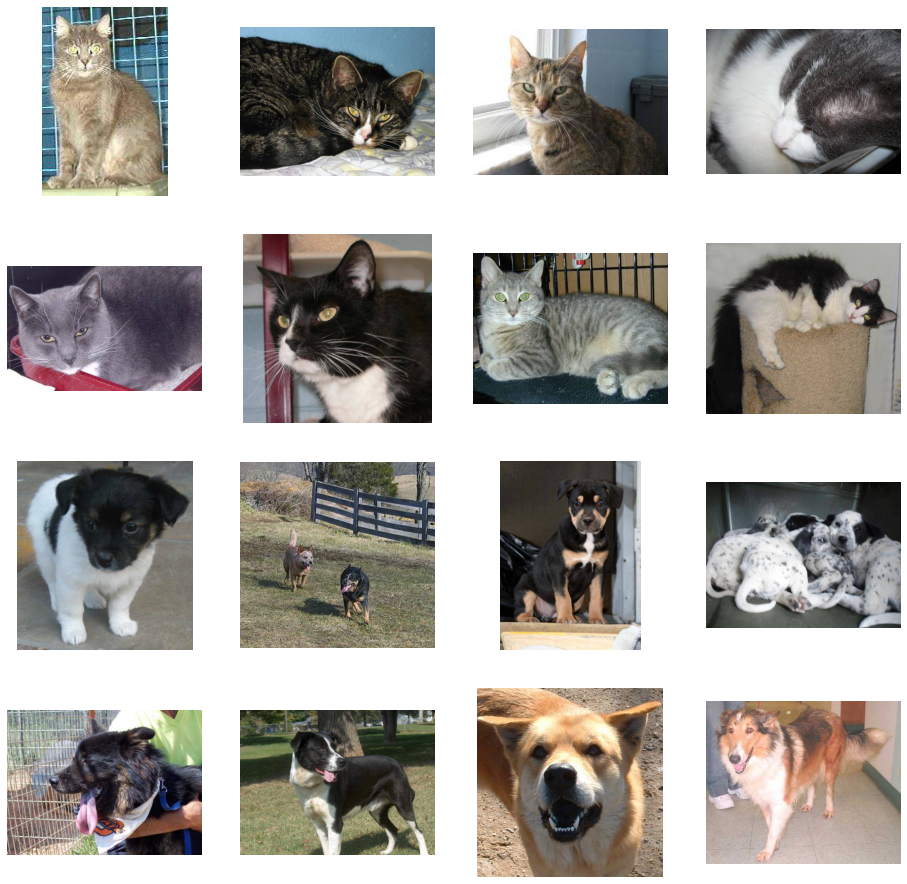

In [15]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[ pic_index-8:pic_index] 
               ]

next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [16]:
model = tf.keras.models.Sequential([
    Conv2D(16,(3,3), activation='relu', input_shape=(150,150,3)),
    MaxPooling2D(2,2),
    Conv2D(32,(3,3),activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64,(3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

In [18]:
model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

In [19]:
datagen = ImageDataGenerator(rescale = 1.0/255.)

train_generator = datagen.flow_from_directory(train_dir,
                                              batch_size=20,
                                              class_mode ='binary',
                                              target_size=(150,150))
validation_generator = datagen.flow_from_directory(validation_dir,
                                                   batch_size=20,
                                                   class_mode='binary',
                                                   target_size = (150,150))

Found 17500 images belonging to 2 classes.
Found 7500 images belonging to 2 classes.


(20, 150, 150, 3)
1.0


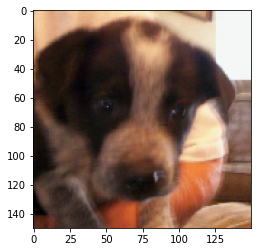

(20, 150, 150, 3)
1.0


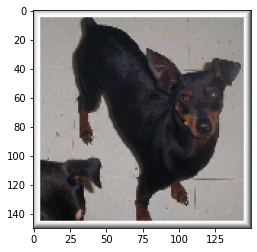

(20, 150, 150, 3)
1.0


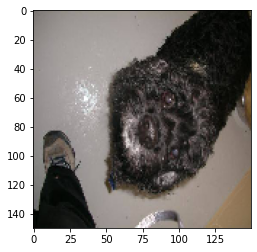

(20, 150, 150, 3)
0.0


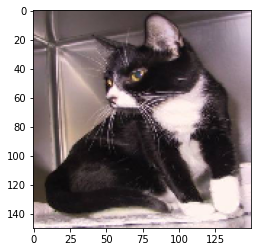

(20, 150, 150, 3)
1.0


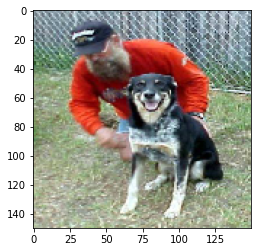

In [20]:
for _ in range(5):
    img, label = train_generator.next()
    print(img.shape)   #  (1,256,256,3)
    print(label[0])
    plt.imshow(img[0])
    plt.show()

In [21]:
histroy = model.fit(train_generator,
                    validation_data = validation_generator,
                    steps_per_epoch=100,
                    epochs=15,
                    validation_steps = 50,
                    verbose=1)

Epoch 1/15
100/100 [==============================] - 23s 131ms/step - loss: 0.7941 - accuracy: 0.5490 - val_loss: 0.6582 - val_accuracy: 0.5830
Epoch 2/15
100/100 [==============================] - 11s 106ms/step - loss: 0.6522 - accuracy: 0.6415 - val_loss: 0.5783 - val_accuracy: 0.7100
Epoch 3/15
100/100 [==============================] - 10s 105ms/step - loss: 0.6002 - accuracy: 0.6800 - val_loss: 0.5751 - val_accuracy: 0.6900
Epoch 4/15
100/100 [==============================] - 11s 109ms/step - loss: 0.5801 - accuracy: 0.7015 - val_loss: 0.6241 - val_accuracy: 0.6720
Epoch 5/15
100/100 [==============================] - 11s 106ms/step - loss: 0.5664 - accuracy: 0.7080 - val_loss: 0.5423 - val_accuracy: 0.7370
Epoch 6/15
100/100 [==============================] - 11s 106ms/step - loss: 0.5304 - accuracy: 0.7410 - val_loss: 0.6072 - val_accuracy: 0.6910
Epoch 7/15
100/100 [==============================] - 11s 106ms/step - loss: 0.5256 - accuracy: 0.7395 - val_loss: 0.5666 - val_ac

In [25]:
from google.colab import files
uploaded=files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path='/content/' + fn
  img=image.load_img(path, target_size=(150, 150))
  
  x=image.img_to_array(img)
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])
  
  classes = model.predict(images, batch_size=10)
  
  print(classes[0])
  
  if classes[0]>0:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")
 

Saving dog.jpg to dog.jpg
[1.]
dog.jpg is a dog


In [26]:
# save weights
model.save('cat_v_dog_model.h5')

In [27]:
model = tf.keras.models.load_model('cat_v_dog_model.h5')

In [28]:
successive_outputs = [layer.output for layer in model.layers[0:]]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
visualization_model

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


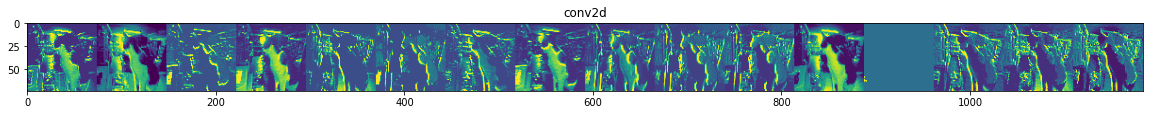

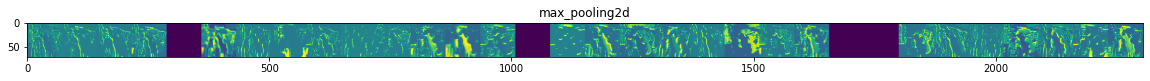

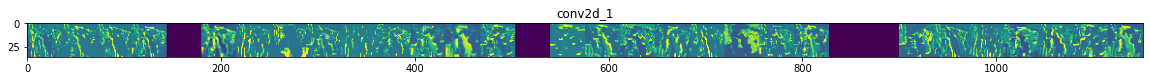

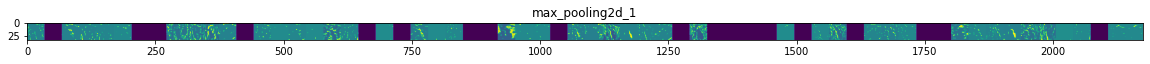

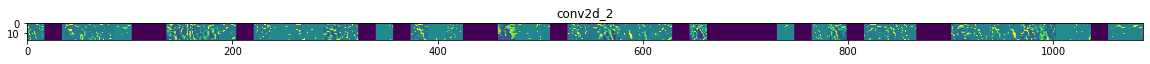

In [29]:
# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]

img_path = random.choice(cat_img_files + dog_img_files)
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image

x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255.0

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# -----------------------------------------------------------------------
# Now let's display our representations
# -----------------------------------------------------------------------
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------

    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' )